# Code for Identifying and Evaluating the Best Feedback Vertex Set Subsets

Here we present our code to demonstrate how we ranked feedback vertex set (FVS) subsets to predict their ability to control the network. We present the code by finding and evaluating the subsets of the T-LGL network and use this to demonstrate how the graphs in the paper were generated.

In [1]:
import networkx as nx
from FVS_python import FVS as FVS
import pandas as pd
import itertools
import numpy as np
import scipy as sc
import numpy.linalg as la
import math
import scipy.stats as sp
import biolqm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from FindBestSubsets import findBestFVSSubsets as find
from RunSimulations import calculateToandAwayControl as simul

## Finding and ranking FVS subsets

The `findBestFVSSubsets` function takes a network as a GraphML file and using the topology of the network ranks the FVS subsets to predict which subsets are most likely to control the network. This function takes as input:
- `netName`: A network in GraphML format
- `numNodes`: The size of the FVS subsets

and has the optional parameters:
- `intersections`: a list of the intersections metrics to be tested
    - Defaults to the three intersection metrics from the paper and CheiRank metric, but they can instead be modified to test any combination of the seven topological metrics. For different intersection metrics, only the metric names `OutDegree`, `Distance`, `PRINCE`, `ModPRINCE`, `CheiRank`, `Cycles`, and `SCC` are recognized.
- `verbose`: A Boolean value to display an output
    - Defaults to False
- `write`: A Boolean value to write the results to an excel file
    - Defaults to False
- `writePath`: The path to write the results to.
    - Defaults to the excel file `TopologicalValues.xlsx`

In [2]:
numNodes = 2
topoVals, interVals, subsets = find('Models/TLGL.graphml', numNodes, write = True, writePath = 'TLGL Results/'+str(numNodes)+'-NodeTopologyVals.xlsx')

This method returns:
- A list of the FVS subsets of size `numNodes`

In [3]:
subsets

['LCK, P2',
 'CTLA4, IL2RA',
 'CTLA4, LCK',
 'IL2RA, TBET',
 'IL2RA, TCR',
 'LCK, TCR',
 'DISC, P2',
 'DISC, LCK',
 'CTLA4, P2',
 'IL2RA, LCK',
 'GAP, GRB2',
 'IL2RA, P2',
 'IL2RA, ZAP70',
 'CTLA4, ZAP70',
 'GAP, LCK',
 'TCR, ZAP70',
 'P2, ZAP70',
 'GRB2, LCK',
 'GAP, ZAP70',
 'GRB2, ZAP70',
 'CTLA4, DISC',
 'DISC, IL2RA',
 'P2, TCR',
 'CTLA4, GAP',
 'BID, IL2RA',
 'CTLA4, FLIP',
 'FLIP, LCK',
 'CTLA4, GRB2',
 'BID, CTLA4',
 'GAP, IL2RA',
 'BID, DISC',
 'BID, P2',
 'BID, LCK',
 'DISC, ZAP70',
 'GAP, P2',
 'FLIP, IL2RA',
 'GAP, RAS',
 'IL2RA, JAK',
 'GAP, TCR',
 'DISC, GAP',
 'FLIP, P2',
 'BID, TCR',
 'DISC, TCR',
 'GRB2, P2',
 'FLIP, TCR',
 'IL2RA, IL2RB',
 'CTLA4, JAK',
 'BID, GAP',
 'FLIP, ZAP70',
 'GRB2, TCR',
 'CTLA4, TBET',
 'TBET, TCR',
 'LCK, TBET',
 'TBET, ZAP70',
 'BID, ZAP70',
 'DISC, GRB2',
 'GRB2, IL2RA',
 'JAK, TCR',
 'CTLA4, IL2RB',
 'P2, TBET',
 'DISC, TBET',
 'FLIP, TBET',
 'FLIP, GAP',
 'FLIP, GRB2',
 'JAK, LCK',
 'CTLA4, RAS',
 'LCK, RAS',
 'GAP, TBET',
 'IL2RB, TCR',

- A DataFrame of the topological metric values for every subset of size `numNodes`

In [4]:
topoVals

,OutDegree,Distance,PRINCE,ModPRINCE,CheiRank,Cycles,SCC
"A20, NFKB",12.0,0.286706,0.010724,0.020680,0.074,0.0,0.0
"A20, Apoptosis",1.0,0.195569,0.005625,0.004795,0.012,0.0,0.0
"A20, Caspase",3.0,0.205291,0.008037,0.006999,0.019,0.0,0.0
"A20, BID",4.0,0.208069,0.008384,0.007519,0.024,0.0,0.0
"A20, GZMB",4.0,0.210847,0.008539,0.006734,0.018,0.0,0.0
...,...,...,...,...,...,...,...
"Proliferation, TAX",1.0,0.197077,0.006048,0.004877,0.012,0.0,0.0
"Proliferation, TNF",2.0,0.202354,0.006752,0.006448,0.016,0.0,0.0
"SPHK1, TAX",2.0,0.228135,0.012261,0.013365,0.031,0.0,0.0
"SPHK1, TNF",3.0,0.233413,0.012502,0.014476,0.036,0.0,0.0


- A DataFrame of the intersection metric values of the input intersections for the FVS subsets of size `numNodes`

In [5]:
interVals

,"OutDegree, Distance, PRINCE, ModPRINCE, CheiRank, Cycles, SCC","PRINCE, ModPRINCE, CheiRank","ModPRINCE, CheiRank",CheiRank
"LCK, P2",0.0,0.0,0.0,0.0
"CTLA4, IL2RA",0.0,0.0,0.0,16.0
"CTLA4, LCK",0.0,1.0,1.0,3.0
"IL2RA, TBET",0.0,22.0,37.0,57.0
"IL2RA, TCR",1.0,1.0,4.0,38.0
...,...,...,...,...
"BID, NFKB",86.0,86.0,90.0,93.0
"IL2RB, NFKB",91.0,91.0,96.0,96.0
"GRB2, NFKB",92.0,92.0,93.0,94.0
"NFKB, RAS",96.0,96.0,97.0,97.0


## Evaluating the identified FVS subsets
After we predicted the ability for the FVS subsets to control the network, we evaluate our predictions using our devised *To Control* and *Away Control* metrics. The `calculateToandAwayControl`function utilizes the bioLQM package to simulate the dynamics of the network and determines the control values of the input subsets. This function takes as input:
- `netName`: A Boolean network model in an import format of the bioLQM package
- `subsets`: The subsets to calculate the *To Control* and *Away Control* values
    - For multi-node subsets, they are added to the list as a comma  spearated string (e.g., the subset of NFKB and S1P would be in the list as the string`'NFKB, S1P'`)

and takes as optional parameters:
- `wtSims`: The number of simulations to run on the wild-type system
    - Defaults to 10 and was set to 1000 in the paper
- `subsetSims`: The number of simulations to run on the system with each intervention
    - Defaults to 10 and was set to 100 in the paper
- `seed`: The random seed used for picking the initial conditions and asynchronous update scheme
    - Defaults to 0
- `verbose`: A Boolean value to display an output
    - Defaults to False
- `write`: A Boolean value to write the results to an excel file
    - Defaults to False
- `writePath`: The path to write the results to.
    - Defaults to the excel file `ControlValues.xlsx`

In [6]:
controlVals, goodTo, goodAway = simul('Models/TLGL.booleannet', subsets, write = True, writePath = 'TLGL Results/'+str(numNodes)+'-NodeControlVals.xlsx')

This method returns:
- The *To Control* and *Away Control* values for each subset

In [7]:
controlVals

,To Control,Away Control
"LCK, P2",0.5,0.63
"CTLA4, IL2RA",0.0,0.40
"CTLA4, LCK",0.0,0.70
"IL2RA, TBET",0.0,1.00
"IL2RA, TCR",0.0,0.40
...,...,...
"BID, NFKB",0.0,1.00
"IL2RB, NFKB",0.0,1.00
"GRB2, NFKB",0.0,1.00
"NFKB, RAS",0.0,1.00


- A dictionary showing if each subset is partially informative (at least one intervention in the subset does not drive the system to every attractor simultaneously).

In [8]:
goodAway

{'LCK, P2': True,
 'CTLA4, IL2RA': True,
 'CTLA4, LCK': True,
 'IL2RA, TBET': True,
 'IL2RA, TCR': True,
 'LCK, TCR': True,
 'DISC, P2': True,
 'DISC, LCK': True,
 'CTLA4, P2': True,
 'IL2RA, LCK': True,
 'GAP, GRB2': True,
 'IL2RA, P2': True,
 'IL2RA, ZAP70': True,
 'CTLA4, ZAP70': True,
 'GAP, LCK': True,
 'TCR, ZAP70': True,
 'P2, ZAP70': True,
 'GRB2, LCK': True,
 'GAP, ZAP70': True,
 'GRB2, ZAP70': True,
 'CTLA4, DISC': True,
 'DISC, IL2RA': True,
 'P2, TCR': True,
 'CTLA4, GAP': True,
 'BID, IL2RA': True,
 'CTLA4, FLIP': True,
 'FLIP, LCK': True,
 'CTLA4, GRB2': True,
 'BID, CTLA4': True,
 'GAP, IL2RA': True,
 'BID, DISC': True,
 'BID, P2': True,
 'BID, LCK': True,
 'DISC, ZAP70': True,
 'GAP, P2': True,
 'FLIP, IL2RA': True,
 'GAP, RAS': True,
 'IL2RA, JAK': True,
 'GAP, TCR': True,
 'DISC, GAP': True,
 'FLIP, P2': True,
 'BID, TCR': True,
 'DISC, TCR': True,
 'GRB2, P2': True,
 'FLIP, TCR': True,
 'IL2RA, IL2RB': True,
 'CTLA4, JAK': True,
 'BID, GAP': True,
 'FLIP, ZAP70': Tru

- A dictionary showing if each subset is fully informative (at least one intervention in the subset does not drive the system to every attractor simultaneously and targets at least one attractor).

In [9]:
goodTo

{'LCK, P2': True,
 'CTLA4, IL2RA': False,
 'CTLA4, LCK': False,
 'IL2RA, TBET': False,
 'IL2RA, TCR': False,
 'LCK, TCR': False,
 'DISC, P2': True,
 'DISC, LCK': True,
 'CTLA4, P2': False,
 'IL2RA, LCK': False,
 'GAP, GRB2': False,
 'IL2RA, P2': True,
 'IL2RA, ZAP70': False,
 'CTLA4, ZAP70': False,
 'GAP, LCK': False,
 'TCR, ZAP70': False,
 'P2, ZAP70': True,
 'GRB2, LCK': False,
 'GAP, ZAP70': False,
 'GRB2, ZAP70': False,
 'CTLA4, DISC': False,
 'DISC, IL2RA': True,
 'P2, TCR': False,
 'CTLA4, GAP': False,
 'BID, IL2RA': True,
 'CTLA4, FLIP': False,
 'FLIP, LCK': True,
 'CTLA4, GRB2': False,
 'BID, CTLA4': False,
 'GAP, IL2RA': False,
 'BID, DISC': True,
 'BID, P2': True,
 'BID, LCK': True,
 'DISC, ZAP70': True,
 'GAP, P2': True,
 'FLIP, IL2RA': True,
 'GAP, RAS': False,
 'IL2RA, JAK': False,
 'GAP, TCR': False,
 'DISC, GAP': True,
 'FLIP, P2': True,
 'BID, TCR': False,
 'DISC, TCR': False,
 'GRB2, P2': True,
 'FLIP, TCR': False,
 'IL2RA, IL2RB': False,
 'CTLA4, JAK': False,
 'BID, G

### Construction of Figure 4
After calculating the topological metric values and control values, we plot them against each other to generate a scatter plot. A logistic regression is applied to this scatter plot and used to generate a Precision-Recall Curve and AUPRC value.

              precision    recall  f1-score   support

       False       0.69      0.61      0.65        44
        True       0.81      0.86      0.84        86

    accuracy                           0.78       130
   macro avg       0.75      0.74      0.74       130
weighted avg       0.77      0.78      0.77       130

Random Threshold: 0.66 
Success Threshold: 0.83 
AUPRC: 0.9


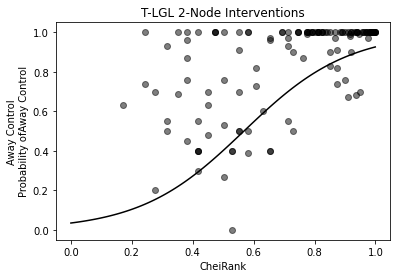

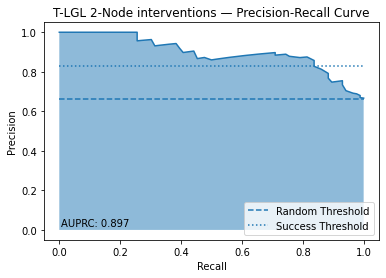

In [10]:
topoMetric = 'CheiRank'
controlMetric = 'Away Control'
topoDF = topoVals[topoMetric].rank()/len(topoVals)
tV = topoDF.to_dict()
cV = controlVals[controlMetric].to_dict()
x = []
y = []
for k in tV.keys():
    if k in subsets:
        x.append(tV[k])
        y.append(cV[k])

x = np.array(x).reshape(-1,1)
y = np.array(y)
yTrue = y >= 0.9
plt.figure(0)
plt.plot(x, y, 'ko', alpha = 0.5)
logReg = LogisticRegression(random_state = 0, C = 1000000000.0, solver = 'liblinear').fit(x,yTrue)
xFit = np.linspace([0],max(x),100)
yFit = logReg.predict_proba(xFit)[:,1]
plt.xlabel(topoMetric)
plt.ylabel(controlMetric+'\nProbability of'+controlMetric)
plt.title('T-LGL '+str(numNodes)+'-Node Interventions')
plt.plot(xFit, yFit, 'k')
yPred = logReg.predict(x)
yScore = logReg.predict_proba(x)[:,1]
posFraction = sum(yTrue)/len(yTrue)
AUPRCThresh = 1-(1-posFraction)/2
plt.figure(1)
AUPRC = metrics.average_precision_score(yTrue, yScore)
A,B,C = metrics.precision_recall_curve(yTrue, yScore)
plt.plot(B, A)
plt.fill_between(B, A, alpha = 0.5)
plt.hlines(posFraction, 0,1,linestyles = '--', label = 'Random Threshold')
plt.hlines(AUPRCThresh, 0,1, linestyles = ':', label = 'Success Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('T-LGL '+str(numNodes)+'-Node interventions — Precision-Recall Curve')
plt.legend(loc = 4)
plt.annotate('AUPRC: '+str(np.round(AUPRC,3)), (17,14), xycoords = 'axes points')
print(metrics.classification_report(yTrue, yPred))
print('Random Threshold:',np.round(posFraction, decimals = 2),\
      '\nSuccess Threshold:',np.round(AUPRCThresh, decimals = 2),\
      '\nAUPRC:',np.round(metrics.average_precision_score(yTrue, yScore), decimals = 2))

### Construction of Figures 6
The intersection metric values are compared to the control values to create figure 6a.

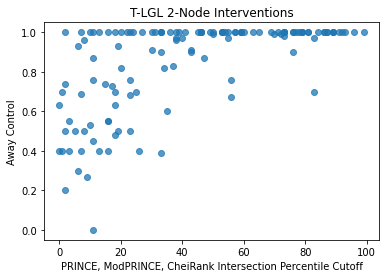

In [11]:
intersections = ['OutDegree, Distance, PRINCE, ModPRINCE, CheiRank, Cycles, SCC', 'PRINCE, ModPRINCE, CheiRank','ModPRINCE, CheiRank','CheiRank']
intersection = intersections[1]
controlMetric = 'Away Control'
iV = interVals[intersection].to_dict()
cV = controlVals[controlMetric].to_dict()
x = []
y = []
for k in iV.keys():
    x.append(iV[k])
    y.append(cV[k])

x = np.array(x).reshape(-1,1)
y = np.array(y)
yTrue = y >= 0.9
plt.figure(0)
plt.plot(x, y, 'o', alpha = 0.75)
plt.xlabel(intersection+' Intersection Percentile Cutoff')
plt.ylabel(controlMetric)
plt.title('T-LGL '+str(numNodes)+'-Node Interventions')

thresholdTests = np.linspace(0.01, 1, 100)
precisionPoint = 1
precisionPoints = []
for t in thresholdTests:
    tp, fp = 0,0
    for i in range(len(x)):
        if(x[i] >= t*100 and y[i] >= 0.9):
            tp += 1
        elif(x[i] >= t*100):
            fp += 1
    if(tp+fp > 0):
        precision = tp/(tp+fp)
    else:
        precision = 0
    precisionPoints.append(precision)
    if(precision >= 0.95):
        precisionPoint = min(t, precisionPoint)

The AUPRC's of the graphs of each of the different intersection metrics, used to generate figure 6b (and figure 6c using the NSCLC network).

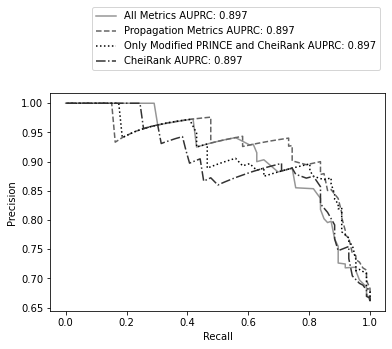

In [12]:
linestyleDict = {1:'-',2:'--',3:':',4:'-.'}
colorDict = {1:'#969696', 2:'#646464',3:'#000000',4:'#323232'}
metricNameDict = {1:'All Metrics', 2:'Propagation Metrics', 3:'Only Modified PRINCE and CheiRank', 4:'CheiRank'}
for i in range(4):
    intersection = intersections[i]
    iV = interVals[intersection].to_dict()
    cV = controlVals[controlMetric].to_dict()
    x = []
    y = []
    for k in iV.keys():
        if(k in subsets):
            x.append(iV[k])
            y.append(cV[k])

    x = np.array(x).reshape(-1,1)
    y = np.array(y)
    yTrue = y >= 0.9
    logReg = LogisticRegression(random_state = 0, C = 100, solver = 'liblinear').fit(x, yTrue)
    yScore = logReg.predict_proba(x)[:,1]
    precision, recall, thresholds = metrics.precision_recall_curve(yTrue, yScore)
    precision = np.insert(precision, 0, posFraction)
    recall = np.insert(recall, 0, 1)
    plt.plot(recall, precision, linestyleDict[i+1], label = metricNameDict[i+1]+' AUPRC: '+str(np.round(AUPRC, decimals = 3)), color = colorDict[i+1])
    plt.legend(bbox_to_anchor = (1,1.42))
    plt.xlabel('Recall')
    plt.ylabel('Precision')

Each intersection metric value is also plotted against CheiRank's percentile cutoff values to generate figures 6d-f.

<ipython-input-13-5e90b30465ce>:32: RuntimeWarning: invalid value encountered in double_scalars
  if((nodeDict[node][1]-nodeDict[node][i+2])/nodeDict[node][1] > 0.2):
<ipython-input-13-5e90b30465ce>:39: RuntimeWarning: invalid value encountered in double_scalars
  if(pd.isna((nodeDict[node][1]-nodeDict[node][i+2])/nodeDict[node][1])):


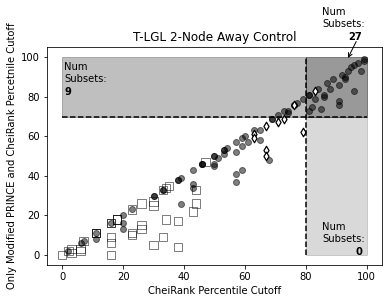

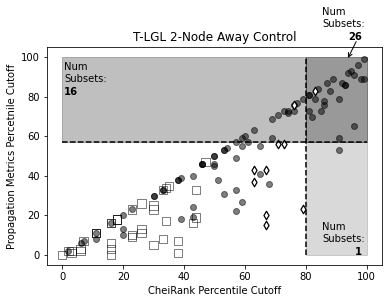

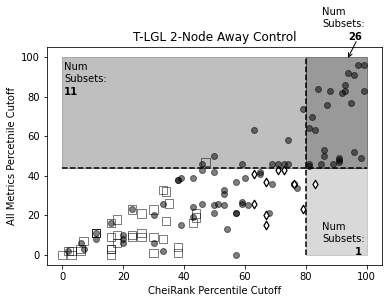

In [13]:
nodeDict = {}
cV = controlVals[controlMetric].to_dict()
for k in cV.keys():
    nodeDict[k] = [cV[k],interVals[intersections[3]][k],interVals[intersections[2]][k],interVals[intersections[1]][k],interVals[intersections[0]][k]]

bigDrops = []
avgsPos = []
avgsNeg = []
for i in range(3):
    badK = ['BID, JAK', 'FLIP, JAK', 'IL2RA, JAK', 'JAK, LCK', 'JAK, P2', 'JAK, ZAP70', 'S1P, TCR', 'CTLA4, S1P','CTLA4, JAK', 'JAK, TCR']
    xGood = []
    xBad = []
    xJAK = []
    yGood = []
    yBad = []
    yJAK = []
    bigDrop = []
    avgPos = 0
    numPos = 0
    avgNeg = 0
    numNeg = 0
    for node in nodeDict.keys():
        if(node in badK):
            xJAK.append(nodeDict[node][1])
            yJAK.append(nodeDict[node][i+2])
        elif(nodeDict[node][0] > 0.9):
            xGood.append(nodeDict[node][1])
            yGood.append(nodeDict[node][i+2])
        else:
            xBad.append(nodeDict[node][1])
            yBad.append(nodeDict[node][i+2])
        if((nodeDict[node][1]-nodeDict[node][i+2])/nodeDict[node][1] > 0.2):
            bigDrop.append((node,nodeDict[node][0] >= 0.9))
        if(nodeDict[node][0] >= 0.9):
            numPos += 1
            avgPos += (nodeDict[node][1]-nodeDict[node][i+2])/nodeDict[node][1]
        else:
            numNeg += 1
            if(pd.isna((nodeDict[node][1]-nodeDict[node][i+2])/nodeDict[node][1])):
                avgNeg += 0
            else:
                avgNeg += (nodeDict[node][1]-nodeDict[node][i+2])/nodeDict[node][1]
    bigDrops.append(bigDrop)
    avgsPos.append(avgPos/numPos)
    avgsNeg.append(avgNeg/numNeg)
    plt.figure(i)
    plt.scatter(xGood,yGood, c = 'k', alpha = 0.5)
    plt.scatter(xBad, yBad, facecolors = 'none', s = 70, edgecolors = 'k', marker = 's', alpha = 0.5)
    plt.xlabel('CheiRank Percentile Cutoff')
    plt.ylabel(metricNameDict[3-i]+' Percetnile Cutoff')
    
    thresholdTests = np.linspace(0, 99, 100)
    crPrecisionPoint = 100
    metPrecisionPoint = 100
    for j in range(len(thresholdTests)):
        t = thresholdTests[-(j+1)]
        crtp, crfp, mettp, metfp = 0,0,0,0
        for node in nodeDict.keys():
            if(nodeDict[node][0] >= 0.9):
                if(nodeDict[node][1] >= t):
                    crtp += 1
                if(nodeDict[node][i+2] >= t):
                    mettp += 1
            else:
                if(nodeDict[node][1] >= t):
                    crfp += 1
                if(nodeDict[node][i+2] >= t):
                    metfp += 1
        if(crtp+crfp > 0):
            crprecision = crtp/(crtp+crfp)
        else:
            crprecision = 0
        if(mettp+metfp > 0):
            metprecision = mettp/(mettp+metfp)
        else:
            metprecision = 0
        if(crprecision >= 0.95):
            crPrecisionPoint = t
        if(metprecision >= 0.95):
            metPrecisionPoint = t
    num1, num2, num3 = 0,0,0
    for node in nodeDict.keys():
        if(nodeDict[node][i+2] >= metPrecisionPoint):
            if(nodeDict[node][1] >= crPrecisionPoint):
                num1 += 1
            else:
                num2 += 1
        elif(nodeDict[node][1] >= crPrecisionPoint):
            num3+=1
    plt.vlines(crPrecisionPoint,0,100,color = 'k',linestyles = 'dashed')
    plt.hlines(metPrecisionPoint,0,100,color = 'k',linestyles = 'dashed')
    plt.fill_between((0,crPrecisionPoint), 100, metPrecisionPoint, color = 'k', alpha = 0.25)
    plt.fill_between((crPrecisionPoint,100), 100, metPrecisionPoint, color = 'k', alpha = 0.4)
    plt.fill_between((crPrecisionPoint,100), metPrecisionPoint, 0, color = 'k', alpha = 0.15)
    plt.annotate('Num\nSubsets:', (17,183), xycoords = 'axes points')
    plt.annotate(str(num2), (17,170), xycoords = 'axes points', weight = 'bold')
    plt.annotate('Num\nSubsets:', (275,238), xycoords = 'axes points')
    plt.annotate(str(num1), (315,225), xycoords = 'axes points', weight = 'bold', ha = 'right')
    plt.annotate('Num\nSubsets:', (275,23), xycoords = 'axes points')
    plt.annotate(str(num3), (315,10), xycoords = 'axes points', weight = 'bold', ha = 'right')
    plt.annotate("", xy=(300, 205), xytext=(310, 225), arrowprops=dict(arrowstyle="->"), xycoords = 'axes points', weight = 'bold')
    plt.scatter(xJAK, yJAK, facecolors = 'none', edgecolors = 'k', facecolor = 'w', marker = 'd', linewidths = 1.25)
    plt.title('T-LGL 2-Node Away Control')

### Contstruction of Figure 7

The precision and number of identified subsets at each percentile cutoff value are plotted against each other to construct figure 7. The 0.9 precision crossing points of the graphs represented by figure 7 are used to find percentile cutoff values that are most appropriate for identifying successful FVS subsets.

Text(10, -45, '0.9 Crossing Point: 68.0')

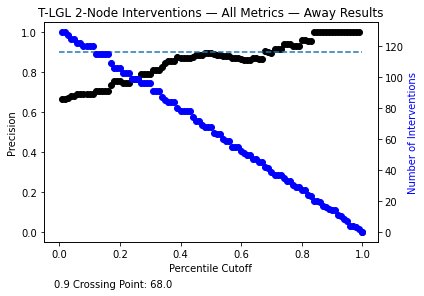

In [14]:
thresholds = np.linspace(0.01,1,100)
precisions = []
numSubsets = []
for t in thresholds:
    num = 0
    tp, fp = 0,0
    for subset in list(interVals.index):
        if(interVals[intersection][subset] >= t*100):
            num += 1
            if(controlVals[controlMetric][subset] >= 0.9):
                tp += 1
            else:
                fp += 1
    precision = 0
    if(tp + fp > 0):
        precision = tp/(tp+fp)
    numSubsets.append(num)
    precisions.append(precision)

fig, ax1 = plt.subplots()
ax1.scatter(thresholds, precisions, color = 'k')
ax2 = ax1.twinx()
ax2.scatter(thresholds, numSubsets, color = 'b')
ax1.hlines(0.9, 0, 1, linestyles = 'dashed')
ax1.set_xlabel('Percentile Cutoff')
ax1.set_ylabel('Precision')
ax2.set_ylabel('Number of Interventions', color = 'b')
cross = 1
for i in range(len(thresholds)-1):
    if(precisions[i] < 0.9 and precisions[i+1] >= 0.9):
        cross = min(cross, thresholds[i+1])
        
plt.title('T-LGL '+str(numNodes)+'-Node Interventions — All Metrics — Away Results')
fig.tight_layout()
s = '0.9 Crossing Point: '+str(np.round(cross*100))
plt.annotate(s, (10,-45), xycoords = 'axes points')

### Construction of Figures 8 and 9
After identifying percentile cutoffs that are expected to identify successful FVS subsets in the high precision and low recall regime, we compared our resulting precision to the precision of a random sample of subsets. Because finding and simulating a random sample of subsets would be too time consuming, we integrate the *To Control* and *Away Control* values of the random sample that we originally chose. This data is in two excel files `TLGLRandomResults.xlsx` and `TLGLRandomFVSResults.xlsx`. We read the data from these two excel files and bootstrap these samples to approximate the precision of the sample of all possible (FVS) subsets. The boostrap function returns the set of precisions resulting from each individual bootstrap, which we then plot as a box-and-whisker plot. We then plot the precision of the subsets we identified using our four percentile cutoff values from our analysis (93 and 83 for *To Control* and 90 and 72.75 for *Away Control*. Here we only look at one intersection metric at a time, but in the paper we look at all three intersection metrics and the CheiRank simultaneously.

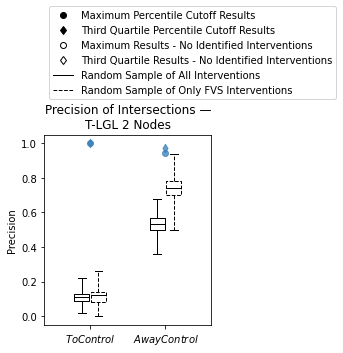

In [15]:
intersection = 'PRINCE, ModPRINCE, CheiRank'

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

def bootstrap(data, numBootstrap):
    bootMeans = []
    np.random.seed(0)
    for _ in range(numBootstrap):
        bootData = np.random.choice(data, size = len(data), replace = True)
        bootMeans.append(bootData.mean())
    return bootMeans

randomSample = pd.read_excel('RandomData/TLGLRandomResults.xlsx', index_col = 0)
randomFVSSample = pd.read_excel('RandomData/TLGLRandomFVSResults.xlsx', index_col = 0)
randomControlDict = {}
randomFVSControlDict = {}

for i in range(len(randomSample)):
    pert = randomSample.index[i]
    vals = randomSample.values[i]
    num = len(pert.split(','))
    if(num == numNodes):
        randomControlDict[pert] = list(vals)
for i in range(len(randomFVSSample)):
    pert = randomFVSSample.index[i]
    vals = randomFVSSample.values[i]
    num = len(pert.split(','))
    if(num == numNodes):
        randomFVSControlDict[pert] = list(vals)

randomTos = (np.array(list(randomControlDict.values()))>=0.9)[:,0]
randomAways = (np.array(list(randomControlDict.values()))>=0.9)[:,1]
randomFVSTos = (np.array(list(randomFVSControlDict.values()))>=0.9)[:,0]
randomFVSAways =  (np.array(list(randomFVSControlDict.values()))>=0.9)[:,1]


randomBoot = np.array([bootstrap(randomTos, 1000), bootstrap(randomAways, 1000)]).transpose()
randomFVSBoot = np.array([bootstrap(randomFVSTos, 1000), bootstrap(randomFVSAways, 1000)]).transpose()

fig, ax = plt.subplots(figsize = (3,3.5))
bp1 = ax.boxplot(randomBoot, whis = [0,100], widths = 0.2, medianprops = dict(color = 'k'), positions = 0.89+np.arange(2))
bp2 = ax.boxplot(randomFVSBoot,whis = [0,100], widths = 0.2, boxprops = dict(linestyle = '--'), whiskerprops = dict(linestyle = '--'), medianprops = dict(color = 'k'), positions = 1.11+np.arange(2))
ax.set_xticks(1+np.arange(2))
ax.set_xticklabels(["$\it{To Control}$","$\it{Away Control}$"])

toGoodMax, toNumMax, toGoodQ3, toNumQ3, awayGoodMax, awayNumMax, awayGoodQ3, awayNumQ3 = 0, 0, 0, 0, 0, 0, 0, 0

for subset in subsets:
    if(goodTo[subset]):
        if(interVals[intersection][subset] >= 91):
            toNumMax += 1
            if(controlVals['To Control'][subset] >= 0.9):
                toGoodMax += 1
        if(interVals[intersection][subset] >= 87):
            toNumQ3 += 1
            if(controlVals['To Control'][subset] >= 0.9):
                toGoodQ3 += 1
    if(goodAway[subset]):
        if(interVals[intersection][subset] >= 80):
            awayNumMax += 1
            if(controlVals['Away Control'][subset] >= 0.9):
                awayGoodMax += 1
        if(interVals[intersection][subset] >= 61):
            awayNumQ3 += 1
            if(controlVals['Away Control'][subset] >= 0.9):
                awayGoodQ3 += 1


if(toNumMax > 0):
    ax.scatter(1, toGoodMax/toNumMax, c= CB_color_cycle[0], marker = 'o', alpha = 0.75, label = 'Intersection of All Metrics')
else:
    ax.scatter(1, 0, c = 'none', edgecolor = CB_color_cycle[0], marker = 'o', alpha = 0.75, label = 'Intersection of All Metrics - No Identified Interventions')
if(toNumQ3 > 0):
    ax.scatter(1, toGoodQ3/toNumQ3, c= CB_color_cycle[0], marker = 'd', alpha = 0.75, label = 'Intersection of All Metrics')
else:
    ax.scatter(1, 0, c = 'none', edgecolor = CB_color_cycle[0], marker = 'd', alpha = 0.75, label = 'Intersection of All Metrics - No Identified Interventions')

if(awayNumMax > 0):
    ax.scatter(2, awayGoodMax/awayNumMax, c= CB_color_cycle[0], marker = 'o', alpha = 0.75, label = 'Intersection of All Metrics')
else:
    ax.scatter(2, 0, c = 'none', edgecolor = CB_color_cycle[0], marker = 'o', alpha = 0.75, label = 'Intersection of All Metrics - No Identified Interventions')
if(awayNumQ3 > 0):
    ax.scatter(2, awayGoodQ3/awayNumQ3, c= CB_color_cycle[0], marker = 'd', alpha = 0.75, label = 'Intersection of All Metrics')
else:
    ax.scatter(2, 0, c = 'none', edgecolor = CB_color_cycle[0], marker = 'd', alpha = 0.75, label = 'Intersection of All Metrics - No Identified Interventions')

ax.set_ylabel('Precision')
ax.set_title('Precision of Intersections —\nT-LGL '+str(numNodes)+' Nodes')

circle_patch = mlines.Line2D([],[],linestyle='None', marker = 'o', color = 'k', label = 'Circle')
diamond_patch = mlines.Line2D([],[],linestyle='None', marker = 'd', color = 'k', label = 'Diamond')
empty_circle_patch = mlines.Line2D([],[],linestyle='None', marker = 'o', color = 'k', label = 'Circle', fillstyle='none')
empty_diamond_patch = mlines.Line2D([],[],linestyle='None', marker = 'd', color = 'k', label = 'Diamond', fillstyle='none')

plt.legend([circle_patch, diamond_patch, empty_circle_patch, empty_diamond_patch, bp1['boxes'][0], bp2['boxes'][0]],\
           ['Maximum Percentile Cutoff Results','Third Quartile Percentile Cutoff Results','Maximum Results - No Identified Interventions','Third Quartile Results - No Identified Interventions','Random Sample of All Interventions','Random Sample of Only FVS Interventions'],\
           loc = 'upper left', bbox_to_anchor = (0,1.7))
